# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
#color = sns.color_palette()
#sns.palplot(sns.color_palette('colorblind'))
sns.set_palette('colorblind')

%matplotlib inline

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# cross validation 
from sklearn.model_selection import train_test_split, StratifiedKFold

# hyper-parameter tuning
from sklearn.grid_search import GridSearchCV

# preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, OneHotEncoder

# models
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier

# pipeline
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, log_loss, 
                             brier_score_loss, precision_score, recall_score, f1_score, make_scorer)

from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.decomposition import PCA

/Users/ikononenko/tensorflow/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ikononenko/tensorflow/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import unicodedata
import re

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', unicode(input_str))
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii


In [3]:
# from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [4]:
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
def plot_forest_importances(clf):
    importances = clf.feature_importances_

    important_names = my_features[importances > np.mean(importances)]
    print important_names

    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_test.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_test.shape[1]), importances[indices], yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), my_features[indices], rotation=90)
    plt.xlim([-1, X_test.shape[1]])
    plt.show()


In [5]:
train_df = pd.read_json('train.json').reset_index(drop=True)
test_df = pd.read_json('test.json').reset_index(drop=True)

train_df['test'] = False
test_df['test'] = True

df = train_df.append(test_df).reset_index(drop=True)

In [6]:
df.bathrooms = df.bathrooms.map(lambda b: b if b < 10 else 0)
df.bedrooms = df.bedrooms.map(lambda b: b if b < 10 else 0)

In [59]:
df['bathrooms_as_int'] = df.bathrooms # df.bathrooms.astype(int) # 1.5 -> 1

In [8]:
(min_value, max_value), mean = np.percentile(df.latitude, [1, 99]).tolist(), np.mean(df.latitude)
df.latitude = np.where(df.latitude < min_value, mean, df.latitude)
df.latitude = np.where(df.latitude > max_value, mean, df.latitude)

In [9]:
df['price_log'] = np.log(df.price)

In [10]:
price_max = np.percentile(df.price, 99).tolist()
df.price = np.where(df.price > price_max, price_max, df.price)

In [11]:
df['display_address_clean'] = df.display_address.apply(lambda x: remove_accents(x))
df['street_address_clean'] = df.street_address.apply(lambda x: remove_accents(x))

df.display_address_clean = df.display_address_clean.map(lambda x: ' '.join(x.strip('!@#$%^&*()-_+=;,./\\\'\t')\
                                                    .replace("'",'').lower()\
                                                    .replace(' street', ' st').replace(' avenue', ' ave')\
                                                    .replace(' road', ' rd').replace(' boulevard', ' blvd')\
                                                    .replace(' east', ' e').replace(' west', ' w')\
                                                    .replace('east ', 'e ').replace('west ', 'w ').split()))

df.street_address_clean = df.street_address_clean.map(lambda x: ' '.join(x.strip('!@#$%^&*()-_+=;,./\\\'\t')\
                                                    .replace("'",'').lower()\
                                                    .replace(' street', ' st').replace(' avenue', ' ave')\
                                                    .replace(' road', ' rd').replace(' boulevard', ' blvd')\
                                                    .replace(' east', ' e').replace(' west', ' w')\
                                                    .replace('east ', 'e ').replace('west ', 'w ').split()))

In [12]:
bldg_id_counts = df.building_id.value_counts()
df['listings_in_bldg'] = df.building_id.map(lambda b: bldg_id_counts[b] if b != '0' else 1)

In [13]:
manager_id_counts = df.manager_id.value_counts()
df['listings_per_manager'] = df.manager_id.map(lambda b: manager_id_counts[b] if b != '0' else 1)

In [14]:
def do_lem(str):
    return " ".join([WordNetLemmatizer().lemmatize(word) for word in str.split(" ")])

def do_stem(str):
    return " ".join([PorterStemmer().stem(word) for word in str.split(" ")])

In [15]:
df['description_clean'] = df.description.apply(lambda alist: remove_accents(alist))

df.description_clean = [re.sub(r'[()?!@#$%^&*-;\'\"]', "", line).replace(","," ")\
                                 .replace("<br >", "").replace("<br />","").replace("<p>","").replace("</p>","")\
                                 .replace("<a  website_redacted", "")\
                                 .replace("apartment", "").replace("bedroom", "").replace("bathroom", "")
                                 .lower().strip() for line in df.description_clean]

df.description_clean = [re.sub(re.compile(r'\s+'), " ", line) for line in df.description_clean]
df.description_clean = [do_lem(line) for line in df.description_clean]

In [16]:
def clean_features(alist):
    return [unicode(x).lower().strip('!@#$%^&*()-_+=;,./\\\'\t').replace(' ', '').replace('-','') for x in alist if len(alist)>0 and isinstance(alist, list)]

In [17]:
df['features_clean'] = df.features.apply(lambda alist: clean_features(alist))

In [18]:
df['num_photos'] = df.photos.apply(len)
df['num_features'] = df.features.apply(len)
df['description_size'] = df.description.apply(lambda x: len(x.split(" ")))

df['created'] = pd.to_datetime(df.created)
df['month'] = df.created.dt.month
df['hod'] = df.created.dt.hour
df['dow'] = df.created.dt.dayofweek

In [19]:
df['bb_combined'] = df.bathrooms + df.bedrooms
df['price_per_room'] = df.price / df.bedrooms  
df['price_per_bath'] = df.price / df.bathrooms

In [20]:
#df.bedrooms = df.bedrooms.astype("category")
#df.bathrooms = df.bedrooms.astype("category")

In [21]:
# 'bathrooms_as_int', 'price_log'
my_features = np.array(['bathrooms_as_int', 'bedrooms', 'latitude', 'longitude', 'price_log', 
                        'listings_in_bldg', 'listings_per_manager', 
                        'num_photos', 'num_features', 'description_size', 'hod', 'dow'])

In [22]:
train_df = df[df.test == False]
test_df = df[df.test == True]

In [23]:
X = train_df[my_features].copy()
y = train_df.interest_level.copy()

X.head()

,bathrooms_as_int,bedrooms,latitude,longitude,price_log,listings_in_bldg,listings_per_manager,num_photos,num_features,description_size,hod,dow
0,1,3,40.7145,-73.9425,8.006368,5,235,5,0,95,7,4
1,1,2,40.7947,-73.9667,8.606119,51,194,11,5,9,12,6
2,1,1,40.7388,-74.0018,7.955074,131,314,8,4,94,3,6
3,1,1,40.7539,-73.9677,8.094073,236,470,3,2,80,2,0
4,1,4,40.8241,-73.9493,8.116716,1,51,3,1,68,1,3


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model training

In [25]:
%%time
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)

y_prediction = clf.predict(X_test)
y_probability = pd.DataFrame(data=clf.predict_proba(X_test), columns=clf.classes_)
y_probability.reindex_axis(labels=['low', 'medium', 'high'])

print(classification_report(y_test, y_prediction))
print("Score: %f" % clf.score(X_test, y_test))           # prev: 0.727485
print("Log-loss: %f" % log_loss(y_test, y_probability))  # prev: 0.603970


             precision    recall  f1-score   support

       high       0.55      0.26      0.36       765
        low       0.78      0.93      0.85      6795
     medium       0.48      0.28      0.36      2311

avg / total       0.69      0.73      0.70      9871

Score: 0.729511
Log-loss: 0.604222
CPU times: user 1min 11s, sys: 1.58 s, total: 1min 12s
Wall time: 1min 12s


Confusion matrix, without normalization
[[ 201  279  285]
 [  37 6343  415]
 [ 127 1527  657]]


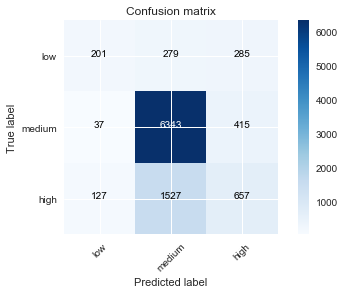

In [26]:
plot_confusion_matrix(confusion_matrix(y_test, y_prediction), classes=['low', 'medium', 'high'])

Confusion matrix, without normalization
[[ 201  279  285]
 [  37 6343  415]
 [ 127 1527  657]]


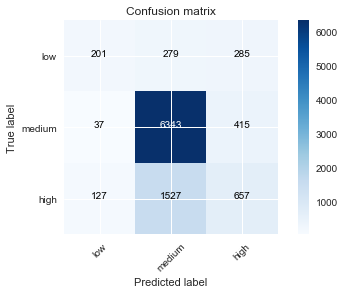

In [27]:
plot_confusion_matrix(confusion_matrix(y_test, y_prediction), classes=['low', 'medium', 'high'])

['latitude' 'longitude' 'price_log' 'listings_in_bldg'
 'listings_per_manager' 'description_size']
Feature ranking:
1. feature 4 (0.161968)
2. feature 9 (0.107869)
3. feature 2 (0.104466)
4. feature 3 (0.104305)
5. feature 6 (0.097749)
6. feature 5 (0.091473)
7. feature 10 (0.077049)
8. feature 7 (0.070060)
9. feature 8 (0.070037)
10. feature 11 (0.062288)
11. feature 1 (0.042817)
12. feature 0 (0.009918)


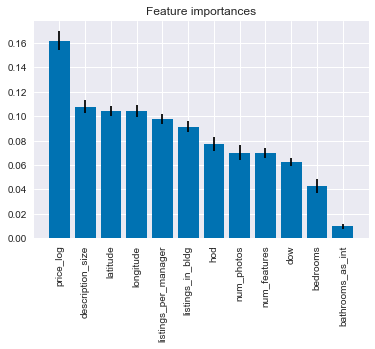

In [28]:
plot_forest_importances(clf)

['latitude' 'longitude' 'price_log' 'listings_in_bldg'
 'listings_per_manager' 'description_size']
Feature ranking:
1. feature 4 (0.161968)
2. feature 9 (0.107869)
3. feature 2 (0.104466)
4. feature 3 (0.104305)
5. feature 6 (0.097749)
6. feature 5 (0.091473)
7. feature 10 (0.077049)
8. feature 7 (0.070060)
9. feature 8 (0.070037)
10. feature 11 (0.062288)
11. feature 1 (0.042817)
12. feature 0 (0.009918)


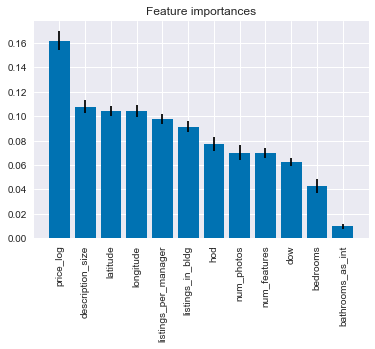

In [29]:
plot_forest_importances(clf)

Internal OOB validation

In [30]:
n_estimators = np.logspace(1, 3, 5).astype(int)
scores = []
for i in n_estimators:
    rf = RandomForestClassifier(n_estimators=i, oob_score=True, n_jobs=-1).fit(X_train, y_train)
    scores.append(rf.oob_score_)

/Users/ikononenko/tensorflow/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ikononenko/tensorflow/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


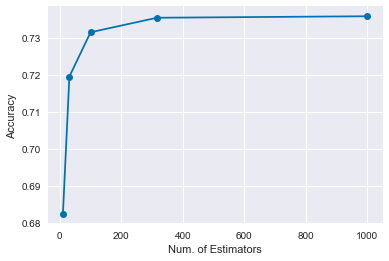

In [31]:
plt.plot(n_estimators, scores, '-o')
plt.xlabel('Num. of Estimators')
plt.ylabel('Accuracy')

In [53]:
from xgboost import XGBClassifier
clf = XGBClassifier(n_estimators=10)
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=10, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [54]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}

In [55]:
get_xgb_imp(clf,my_features)

/Users/ikononenko/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


{'bathrooms_as_int': nan,
 'bedrooms': nan,
 'description_size': nan,
 'dow': nan,
 'hod': nan,
 'latitude': nan,
 'listings_in_bldg': nan,
 'listings_per_manager': nan,
 'longitude': nan,
 'num_features': nan,
 'num_photos': nan,
 'price_log': nan}

In [37]:
param_grid = {'n_estimators': [10, 100, 1000], 'max_features': [2, 6, 12]}
clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring=make_scorer(accuracy_score))

In [38]:
clf.fit(X_train, y_train)
print("Score: %f" % clf.score(X_test, y_test))

/Users/ikononenko/tensorflow/lib/python2.7/site-packages/sklearn/grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


Score: 0.731030


['latitude' 'longitude' 'price_log' 'listings_in_bldg'
 'listings_per_manager' 'description_size']
Feature ranking:
1. feature 4 (0.166575)
2. feature 9 (0.109906)
3. feature 3 (0.105945)
4. feature 2 (0.104935)
5. feature 6 (0.097201)
6. feature 5 (0.089676)
7. feature 10 (0.076654)
8. feature 8 (0.069111)
9. feature 7 (0.068669)
10. feature 11 (0.060945)
11. feature 1 (0.042584)
12. feature 0 (0.007798)


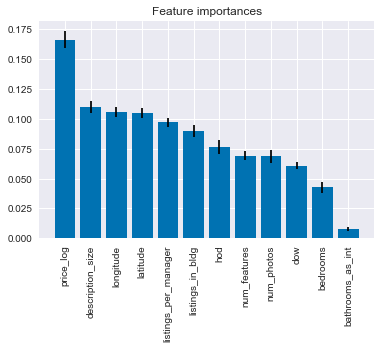

In [39]:
plot_forest_importances(clf.best_estimator_)

In [40]:
%%time
clf = RandomForestClassifier(n_estimators=1000)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('clf', clf)])
pca.fit(X_train)

CPU times: user 24 ms, sys: 101 ms, total: 125 ms
Wall time: 126 ms


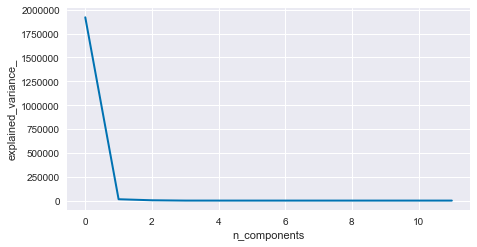

In [41]:
plt.figure(1, figsize=(8, 4))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

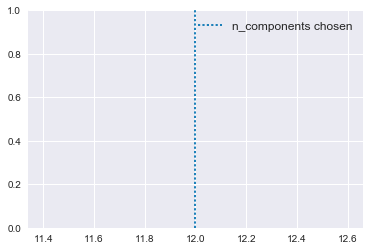

In [42]:
n_components = [2, 6, 12]

grid_search = GridSearchCV(pipe,
                         dict(pca__n_components=n_components))
grid_search.fit(X_train, y_train)

plt.axvline(grid_search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

             precision    recall  f1-score   support

       high       0.59      0.21      0.31       765
        low       0.77      0.94      0.84      6795
     medium       0.49      0.26      0.34      2311

avg / total       0.69      0.73      0.69      9871

Confusion matrix, without normalization
[[ 163  341  261]
 [  25 6399  371]
 [  90 1615  606]]


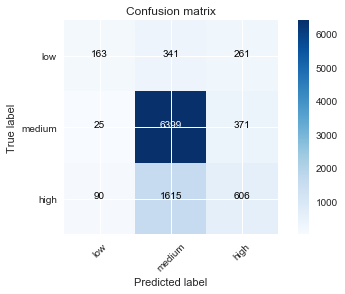

In [43]:
y_prediction = grid_search.predict(X_test)
print(classification_report(y_test, y_prediction))
plot_confusion_matrix(confusion_matrix(y_test, y_prediction), classes=['low', 'medium', 'high'])

In [44]:
print(grid_search.best_estimator_.named_steps["clf"].feature_importances_)

[ 0.07724688  0.07668702  0.07474149  0.09299833  0.07025722  0.07093172
  0.06917632  0.07550567  0.0749305   0.10749362  0.12921214  0.08081908]


['longitude' 'description_size' 'hod']
Feature ranking:
1. feature 10 (0.129212)
2. feature 9 (0.107494)
3. feature 3 (0.092998)
4. feature 11 (0.080819)
5. feature 0 (0.077247)
6. feature 1 (0.076687)
7. feature 7 (0.075506)
8. feature 8 (0.074930)
9. feature 2 (0.074741)
10. feature 5 (0.070932)
11. feature 4 (0.070257)
12. feature 6 (0.069176)


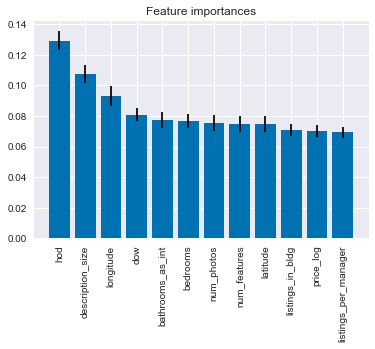

In [45]:
plot_forest_importances(grid_search.best_estimator_.named_steps["clf"])

# Submission saving

Submissions are evaluated using the multi-class logarithmic loss. Submit a set of predicted probabilities (one for every listing).

See details here: https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries#evaluation

In [47]:
%%time
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)

y_prediction = clf.predict(X_test)
y_probability = pd.DataFrame(data=clf.predict_proba(X_test), columns=clf.classes_)
y_probability.reindex_axis(labels=['low', 'medium', 'high'])

print(classification_report(y_test, y_prediction))
print("Score: %f" % clf.score(X_test, y_test))           # prev: 0.727485
print("Log-loss: %f" % log_loss(y_test, y_probability))  # prev: 0.603970


             precision    recall  f1-score   support

       high       0.54      0.26      0.35       765
        low       0.78      0.93      0.85      6795
     medium       0.49      0.28      0.36      2311

avg / total       0.69      0.73      0.70      9871

Score: 0.730220
Log-loss: 0.605159
CPU times: user 1min 10s, sys: 1.61 s, total: 1min 11s
Wall time: 1min 12s


In [48]:
X = train_df[my_features]
y = clf.predict_proba(X)

In [49]:
import datetime
today = datetime.date.today().strftime("%d-%m-%Y")

In [50]:
labels2idx = {label: i for i, label in enumerate(clf.classes_)}
labels2idx

{u'high': 0, u'low': 1, u'medium': 2}

In [51]:
submission = pd.DataFrame()
submission['listing_id'] = train_df['listing_id']
for label in ['high', 'medium', 'low']:
    submission[label] = y[:, labels2idx[label]]
submission.to_csv('submission_%s.csv' % today, index=False)

In [52]:
submission.head()

,listing_id,high,medium,low
0,7211212,0.023,0.745333,0.231667
1,7150865,0.015,0.062000,0.923000
2,6887163,0.690,0.121000,0.189000
3,6888711,0.004,0.056500,0.939500
4,6934781,0.013,0.080000,0.907000
